In [ ]:
!ls

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls "/content/drive/My Drive/"

In [ ]:
!pip install tensorview

     |████████████████████████████████| 71kB 3.7MB/s 
     |████████████████████████████████| 143kB 13.5MB/s 
     |████████████████████████████████| 153kB 17.3MB/s 
     |████████████████████████████████| 133kB 16.3MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 143kB 15.6MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving knat_Combine_Matrix.npy to knat_Combine_Matrix.npy
User uploaded file "knat_Combine_Matrix.npy" with length 2261936 bytes


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving knat_Label.npy to knat_Label.npy
User uploaded file "knat_Label.npy" with length 1032 bytes


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv1D, GRU
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling1D
from tensorflow.keras.layers import LeakyReLU, ReLU,LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

import numpy as np
import math
import matplotlib.pyplot as plt
import tensorview as tv
import tensorflow 
np.random.seed(1)
tensorflow.random.set_seed(3)

seq_length = 6
features_n = 417
SHAPE = (seq_length,features_n)
hidden_dim = 512

def load_datasets(dataset):
    newX = np.load(file=dataset + "_Combine_Matrix.npy")
    label = np.load(file=dataset + "_Label.npy")

    print('Combine (sizes * features * time points): ', newX.shape)
    print('Label size: ', len(label))

    return newX, label

In [ ]:
def generator1(inputs,
              activation='sigmoid',
              labels=None,
              codes=None):
    #generator1 output: fake sample
    #generator1 output size = (SHAPE[0],SHAPE[1])
    if codes is not None:
        inputs = [inputs, codes]
        x = concatenate(inputs, axis=1)
    else:
        x = inputs
    
    x = Dense(SHAPE[0]*SHAPE[1])(x)
    x = Reshape((SHAPE[0], SHAPE[1]))(x)
    x = GRU(834, return_sequences=False, return_state=False,unroll=True)(x)
    x = Reshape((6, int(SHAPE[1]/3)))(x)
    x = Conv1D(512, 6, 1, "same")(x)
    x = BatchNormalization(momentum=0.8)(x) 
    x = Conv1D(417, 6, 1, "same")(x)
    x = BatchNormalization(momentum=0.8)(x)

    if activation is not None:
        x = Activation(activation)(x)
        
    return Model(inputs, x,  name='gen1')


def build_generators(latent_codes, feature0_dim=512):
    #output: gen0, gen1
    #gen0 output:fake_feature0
    #gen0 output size = 512

    labels, z0, z1, feature0 = latent_codes

    # gen0
    inputs = [labels, z0]
    x = concatenate(inputs, axis=1)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    fake_feature0 = Dense(feature0_dim, activation='relu')(x)
    gen0 = Model(inputs, fake_feature0, name='gen0')

    # gen1
    gen1 = generator1(feature0, codes=z1)

    return gen0, gen1


def discriminator1(inputs,z_dim=50):
    #output the probability that sample is real
    #output z1 reonstruction
    x = inputs
    x = GRU(832, return_sequences=False, return_state=False,unroll=True, activation="relu")(x)
    x = Reshape((13,64))(x)
    x = Conv1D(16, 3,2, "same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv1D(32, 3, 2, "same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    outputs = Dense(1)(x)

    z1_recon =  Dense(z_dim)(x)
    z1_recon = Activation('tanh', name='z1')(z1_recon)

    outputs = [outputs, z1_recon]
    dis1=Model(inputs, outputs, name='dis1')
    return dis1


def discriminator0(inputs, z_dim=50):
    #output the probability that feature is real
    #output z0 reonstruction
    x = Dense(72, activation='relu')(inputs)
    x = Dense(72, activation='relu')(x)

    f0_source = Dense(1)(x)
    f0_source = Activation('sigmoid',
                           name='feature1_source')(f0_source)

    z0_recon = Dense(z_dim)(x) 
    z0_recon = Activation('tanh', name='z0')(z0_recon)
    
    discriminator_outputs = [f0_source, z0_recon]
    dis0 = Model(inputs, discriminator_outputs, name='dis0')
    return dis0


def build_encoder(inputs, num_labels, feature0_dim=512):
    x, feature0 = inputs

    # Encoder0
    y = GRU(72, return_sequences=False, return_state=False,unroll=True)(x)
    y = Flatten()(y)
    feature0_output = Dense(feature0_dim, activation='relu')(y)
    enc0 = Model(inputs=x, outputs=feature0_output, name="encoder0")
    
    # Encoder1
    y = Dense(num_labels)(feature0)
    labels = Activation('softmax')(y)
    enc1 = Model(inputs=feature0, outputs=labels, name="encoder1")

    return enc0, enc1


def train_encoder(model,
                  data, 
                  model_name="MTSS-GAN", 
                  batch_size=64):

    (x_train, y_train), (x_test, y_test) = data
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.fit(x_train,
              y_train,
              validation_split=0.1,
              epochs=10,
              batch_size=batch_size)

    model.save(model_name + "-encoder.h5")
    score = model.evaluate(x_test,
                           y_test, 
                           batch_size=batch_size,
                           verbose=0)
    print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))

In [ ]:
def train(models, data, params):
    # the MTSS-GAN and Encoder models

    enc0, enc1, gen0, gen1, dis0, dis1, adv0, adv1 = models
    # network parameters
    batch_size, train_steps, num_labels, z_dim, model_name = params
    # train dataset
    (x_train, y_train), (_, _) = data # I can do this. 
    # the generated time series array is saved every 500 steps
    save_interval = 500

    # label and noise codes for generator testing
    z0 = np.random.normal(scale=0.5, size=[SHAPE[0], z_dim])
    z1 = np.random.normal(scale=0.5, size=[SHAPE[0], z_dim])
    noise_class = np.eye(num_labels)[np.arange(0, SHAPE[0]) % num_labels]
    print(noise_class.shape)
    noise_params = [noise_class, z0, z1]
    # number of elements in train dataset
    train_size = x_train.shape[0]
    print(model_name,
          "Labels for generated time series arrays: ",
          np.argmax(noise_class, axis=1))

    tv_plot = tv.train.PlotMetrics(columns=5, wait_num=5)
    for i in range(train_steps):
        # train the discriminator1 for 1 batch
        # 1 batch of real (label=1.0) and fake feature1 (label=0.0)
        # randomly pick real time series arrays from dataset
        dicta = {}
        rand_indexes = np.random.randint(0, 
                                         train_size, 
                                         size=batch_size)
        real_samples = x_train[rand_indexes]
        # real feature1 from encoder0 output
        real_feature0 = enc0.predict(real_samples)
        # generate random 50-dim z1 latent code
        real_z0 = np.random.normal(scale=0.5,
                                   size=[batch_size, z_dim])
        # real labels from dataset
        real_labels = y_train[rand_indexes]

        # generate fake feature1 using generator1 from
        # real labels and 50-dim z1 latent code
        fake_z0 = np.random.normal(scale=0.5,
                                   size=[batch_size, z_dim])
        fake_feature0 = gen0.predict([real_labels, fake_z0])

        # real + fake data
        feature0 = np.concatenate((real_feature0, fake_feature0))
        z0 = np.concatenate((fake_z0, fake_z0))

        # label 1st half as real and 2nd half as fake
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0

        # train discriminator1 to classify feature1 as 
        # real/fake and recover
        # latent code (z0). real = from encoder1, 
        # fake = from genenerator10
        # joint training using discriminator part of 
        # advserial1 loss and entropy0 loss
        metrics = dis0.train_on_batch(feature0, [y, z0])
        # log the overall loss only
        log = "%d: [dis0_loss: %f]" % (i, metrics[0])
        dicta["dis0_loss"] = metrics[0]
         
        # train the discriminator1 for 1 batch
        # 1 batch of real (label=1.0) and fake time series arrays (label=0.0)
        # generate random 50-dim z1 latent code
        fake_z1 = np.random.normal(scale=0.5, size=[batch_size, z_dim])
        # generate fake time series arrays from real feature1 and fake z1
        fake_samples = gen1.predict([real_feature0, fake_z1])
       
        # real + fake data
        x = np.concatenate((real_samples, fake_samples))
        z1 = np.concatenate((fake_z1, fake_z1))

        # train discriminator1 to classify time series arrays 
        # as real/fake and recover latent code (z1)
        # joint training using discriminator part of advserial0 loss
        # and entropy1 loss
        metrics = dis1.train_on_batch(x, [y, z1])
        # log the overall loss only (use dis1.metrics_names)
        log = "%s [dis1_loss: %f]" % (log, metrics[0])
        dicta["dis1_loss"] = metrics[0]

        # adversarial training 
        # generate fake z0, labels
        fake_z0 = np.random.normal(scale=0.5, 
                                   size=[batch_size, z_dim])
        # input to generator0 is sampling fr real labels and
        # 50-dim z0 latent code
        gen0_inputs = [real_labels, fake_z0]

        # label fake feature0 as real (specifies whether real or not)
        # is it bypassing the discriminator?
        y = np.ones([batch_size, 1])
    
        # train generator0 (thru adversarial) by fooling 
        # the discriminator
        # and approximating encoder1 feature0 generator
        # joint training: adversarial0, entropy0, conditional0
        metrics = adv0.train_on_batch(gen0_inputs,
                                      [y, fake_z0, real_labels])
        fmt = "%s [adv0_loss: %f, enc1_acc: %f]"
        dicta["adv0_loss"] = metrics[0]
        dicta["enc1_acc"] = metrics[6]

        # log the overall loss and classification accuracy
        log = fmt % (log, metrics[0], metrics[6])

        # input to generator0 is real feature0 and 
        # 50-dim z0 latent code
        fake_z1 = np.random.normal(scale=0.5,
                                   size=[batch_size, z_dim])
        
        gen1_inputs = [real_feature0, fake_z1]

        # train generator1 (thru adversarial) by fooling 
        # the discriminator and approximating encoder1 time series arrays 
        # source generator joint training: 
        # adversarial1, entropy1, conditional1
        metrics = adv1.train_on_batch(gen1_inputs,
                                      [y, fake_z1, real_feature0])
        # log the overall loss only
        log = "%s [adv1_loss: %f]" % (log, metrics[0])
        dicta["adv1_loss"] = metrics[0]


        print(log)
        # if (i + 1) % save_interval == 0:
        #     generators = (gen0, gen1)
        #     plot_ts(generators,
        #                 noise_params=noise_params,
        #                 show=False,
        #                 step=(i + 1),
        #                 model_name=model_name)
            
        tv_plot.update({'dis0_loss': dicta["dis0_loss"], 'dis1_loss': dicta["dis1_loss"], 'adv0_loss': dicta["adv0_loss"], 'enc1_acc': dicta["enc1_acc"], 'adv1_loss': dicta["adv1_loss"]})
        tv_plot.draw()

    # save the modelis after training generator0 & 1
    # the trained generator can be reloaded for
    # future data generation
    gen0.save(model_name + "-gen0.h5")
    gen1.save(model_name + "-gen1.h5")

    return  gen0, gen1 
    

def plot_ts(generators,
                noise_params,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake time series arrays and plot them
    For visualization purposes, generate fake time series arrays
    then plot them in a square grid
    # Arguments
        generators (Models): gen0 and gen1 models for 
            fake time series arrays generation
        noise_params (list): noise parameters 
            (label, z0 and z1 codes)
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save time series arrays
        model_name (string): Model name
    """

    gen0, gen1 = generators
    noise_class, z0, z1 = noise_params
    feature0 = gen0.predict([noise_class, z0])
    tss = gen1.predict([feature0, z1])

In [ ]:
def build_and_train_models(train_steps,data):
    (x_train, y_train), (x_test, y_test)=data
    
    num_labels = len(np.unique(y_train))
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    data=(x_train, y_train), (x_test, y_test)
    model_name = "MTSS-GAN"
    batch_size = 64
    lr = 2e-4
    decay = 6e-8
    z_dim = 50 ##this is the noise input
    z_shape = (z_dim, )
    feature0_dim = 512
    feature0_shape = (feature0_dim, )
    optimizer = RMSprop(lr=lr, decay=decay)

    # build discriminator 0 and Q network 0 models
    input_shape = (feature0_dim, )
    inputs = Input(shape=input_shape, name='dis0_input')
    dis0 = discriminator0(inputs, z_dim=z_dim )

    loss = ['binary_crossentropy', 'mse']
    loss_weights = [1.0, 1.0] 
    dis0.compile(loss=loss,
                 loss_weights=loss_weights,
                 optimizer=optimizer,
                 metrics=['accuracy'])
    dis0.summary() 

    # build discriminator 1 and Q network 1 models
    input_shape = (SHAPE[0],SHAPE[1])
    inputs = Input(shape=input_shape, name='dis1_input')
    dis1 = discriminator1(inputs, z_dim=z_dim)

    loss = ['binary_crossentropy', 'mse']
    loss_weights = [1.0, 10.0] ###? why is 10
    dis1.compile(loss=loss,
                 loss_weights=loss_weights,
                 optimizer=optimizer,
                 metrics=['accuracy'])
    dis1.summary() 

    # build generator models
    label_shape = (num_labels, )
    feature0 = Input(shape=feature0_shape, name='feature0_input')
    labels = Input(shape=label_shape, name='labels')
    z0 = Input(shape=z_shape, name="z0_input")
    z1 = Input(shape=z_shape, name="z1_input")
    latent_codes = (labels, z0, z1, feature0)
    gen0, gen1 = build_generators(latent_codes)
    gen0.summary()
    gen1.summary()

    # build encoder models
    input_shape = SHAPE
    inputs = Input(shape=input_shape, name='encoder_input')
    enc0, enc1 = build_encoder((inputs, feature0), num_labels)
    enc0.summary() 
    enc1.summary() 
    encoder = Model(inputs, enc1(enc0(inputs)))
    encoder.summary() 

    print(x_train.shape)
    print(y_train.shape)
    train_encoder(encoder, data, model_name=model_name)


    # build adversarial0 model = 
    # generator0 + discriminator0 + encoder1
    # encoder0 weights frozen
    enc1.trainable = False
    dis0.trainable = False
    gen0_inputs = [labels, z0]
    gen0_outputs = gen0(gen0_inputs)
    adv0_outputs = dis0(gen0_outputs) + [enc1(gen0_outputs)]
    adv0 = Model(gen0_inputs, adv0_outputs, name="adv0")
    
    loss_weights = [1.0, 1.0, 1.0] 
    loss = ['binary_crossentropy', 
            'mse',
            'categorical_crossentropy']
    adv0.compile(loss=loss,
                 loss_weights=loss_weights,
                 optimizer=optimizer,
                 metrics=['accuracy'])
    adv0.summary()

    # build adversarial1 model =
    # generator1 + discriminator1 + encoder0
    optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    enc0.trainable = False
    dis1.trainable = False
    gen1_inputs = [feature0, z1]
    gen1_outputs = gen1(gen1_inputs)
    print(gen1_inputs)
    print(gen1_outputs)
    adv1_outputs = dis1(gen1_outputs)
    adv1_outputs +=  [enc0(gen1_outputs)]
    adv1 = Model(gen1_inputs, adv1_outputs, name="adv1")
    loss = ['binary_crossentropy', 'mse', 'mse']
    loss_weights = [1.0, 10.0, 1.0] ##?why 10
    adv1.compile(loss=loss,
                 loss_weights=loss_weights,
                 optimizer=optimizer,
                 metrics=['accuracy'])
    adv1.summary()

    # train discriminator and adversarial networks
    models = (enc0, enc1, gen0, gen1, dis0, dis1, adv0, adv1)
    params = (batch_size, train_steps, num_labels, z_dim, model_name)
    gen0, gen1 = train(models, data, params)

    return gen0, gen1

In [ ]:
def lstm_model(num_time_step, dim, num_features,model_name="lstm"):
    X = Input(shape=(num_time_step,num_features))  #ndedit
    Y = LSTM(units=dim, return_sequences=False)(X)
    Y = Dense(units=128)(Y)  
    Y = Activation('relu')(Y)
    Y = Dense(units=1)(Y)
    Y = Activation('sigmoid')(Y)
    model = Model(inputs=X, outputs=Y)
    return model

from sklearn.metrics import roc_curve
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import roc_auc_score,f1_score
def build_and_train_lstm_models(data):
    (x_train, y_train), (x_test, y_test)=data
    ### build the lstm model ###
    n_a = 128 
    n_features = 417  
    n_t= 6   
    model = lstm_model(n_t, n_a, n_features)
    opt = SGD(learning_rate=0.1, momentum=0.1)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss',min_delta=0.001,patience=10,restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                                patience=5, min_lr=0.001)  

    ### train the model
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    model.fit(x_train,y_train, epochs=300, shuffle=True,callbacks=[callback,reduce_lr],validation_split=0.1)

    y_pred_prob = model.predict(x_test)

    y_pred_label = (y_pred_prob>[0.5]).astype(int)
    f1_test=f1_score(y_true=y_test, y_pred=y_pred_label)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    interp_tpr = np.interp(mean_fpr, fpr, tpr) 
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

    print("f1_pred:",f1_test)
    print("auc_pred",auc)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f)' % (auc),
            lw=2, alpha=.8)
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
        title="ROC figure")
    ax.legend(loc="lower right")
    plt.show()
    ### clear the graph
    K.clear_session() 
    return auc


In [ ]:
###  train the gan model  ###
steps = 2000
data_x, data_y = load_datasets('knat')
data_x = data_x.transpose(0, 2, 1) 
data_size=data_x.shape[0]
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2)
data=(x_train, y_train), (x_test, y_test)

# gen0, gen1 = build_and_train_models(train_steps = steps,data=data)
gen1=load_model("MTSS-GAN-gen1.h5")
gen0=load_model("MTSS-GAN-gen0.h5")

Combine (sizes * features * time points):  (113, 417, 6)
Label size:  113


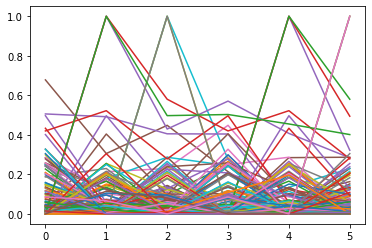

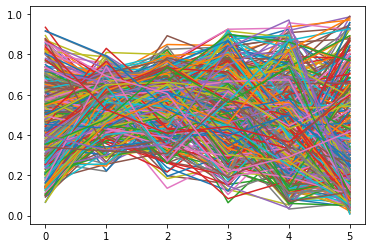

In [ ]:
x=data_x[0,:,:]
plt.plot(x)
plt.show()
x=gen_data[14,:,:]
plt.plot(x)
plt.show()

Epoch 1/300
3/3 [==============================] - 0s 96ms/step - loss: 0.6962 - accuracy: 0.4691 - val_loss: 0.6091 - val_accuracy: 0.8889
Epoch 2/300
3/3 [==============================] - 0s 10ms/step - loss: 0.6375 - accuracy: 0.7284 - val_loss: 0.5429 - val_accuracy: 0.8889
Epoch 3/300
3/3 [==============================] - 0s 10ms/step - loss: 0.6111 - accuracy: 0.7284 - val_loss: 0.5087 - val_accuracy: 0.8889
Epoch 4/300
3/3 [==============================] - 0s 10ms/step - loss: 0.5971 - accuracy: 0.7284 - val_loss: 0.4798 - val_accuracy: 0.8889
Epoch 5/300
3/3 [==============================] - 0s 10ms/step - loss: 0.5866 - accuracy: 0.7284 - val_loss: 0.4565 - val_accuracy: 0.8889
Epoch 6/300
3/3 [==============================] - 0s 10ms/step - loss: 0.5806 - accuracy: 0.7284 - val_loss: 0.4374 - val_accuracy: 0.8889
Epoch 7/300
3/3 [==============================] - 0s 9ms/step - loss: 0.5759 - accuracy: 0.7284 - val_loss: 0.4235 - val_accuracy: 0.8889
Epoch 8/300
3/3 [====

3/3 [==============================] - 0s 13ms/step - loss: 0.3183 - accuracy: 0.8395 - val_loss: 0.3696 - val_accuracy: 0.8889
Epoch 60/300
3/3 [==============================] - 0s 12ms/step - loss: 0.3196 - accuracy: 0.9012 - val_loss: 0.1759 - val_accuracy: 0.8889
Epoch 61/300
3/3 [==============================] - 0s 9ms/step - loss: 0.3272 - accuracy: 0.8272 - val_loss: 0.3342 - val_accuracy: 0.8889
Epoch 62/300
3/3 [==============================] - 0s 9ms/step - loss: 0.3041 - accuracy: 0.8889 - val_loss: 0.2488 - val_accuracy: 0.8889
Epoch 63/300
3/3 [==============================] - 0s 9ms/step - loss: 0.2924 - accuracy: 0.9012 - val_loss: 0.2547 - val_accuracy: 0.8889
Epoch 64/300
3/3 [==============================] - 0s 9ms/step - loss: 0.2890 - accuracy: 0.9012 - val_loss: 0.2882 - val_accuracy: 0.8889
Epoch 65/300
3/3 [==============================] - 0s 9ms/step - loss: 0.2788 - accuracy: 0.8889 - val_loss: 0.1682 - val_accuracy: 0.8889
Epoch 66/300
3/3 [=============

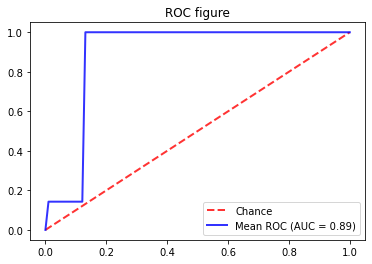

In [ ]:
### base case ###
aucs=[]
auc=build_and_train_lstm_models(data)
aucs.append(auc)

In [ ]:
def generate_data(percent):
    ###  generate the new data  ###
    z_dim=50
    num_labels=2
    nums=(int)(data_size*percent/2)*2
    z0 = np.random.normal(scale=0.5, size=[nums,z_dim])
    z1 = np.random.normal(scale=0.5, size=[nums,z_dim])
    nums=(int)(nums/2)
    y_pos=np.zeros((nums,), dtype=int)
    y_neg=np.ones((nums,), dtype=int)
    y_gan=np.concatenate((y_pos,y_neg))
    noise_class = np.eye(num_labels)[y_gan]
    feature0 = gen0.predict([noise_class, z0])
    gen_data = gen1.predict([feature0, z1])
    return gen_data,y_gan

(100, 6, 417)
(100,)
Epoch 1/300
3/3 [==============================] - 0s 101ms/step - loss: 0.6703 - accuracy: 0.7111 - val_loss: 0.5934 - val_accuracy: 0.9000
Epoch 2/300
3/3 [==============================] - 0s 11ms/step - loss: 0.6384 - accuracy: 0.7000 - val_loss: 0.5329 - val_accuracy: 0.9000
Epoch 3/300
3/3 [==============================] - 0s 11ms/step - loss: 0.6151 - accuracy: 0.7000 - val_loss: 0.4962 - val_accuracy: 0.9000
Epoch 4/300
3/3 [==============================] - 0s 11ms/step - loss: 0.6035 - accuracy: 0.7000 - val_loss: 0.4710 - val_accuracy: 0.9000
Epoch 5/300
3/3 [==============================] - 0s 11ms/step - loss: 0.5949 - accuracy: 0.7000 - val_loss: 0.4499 - val_accuracy: 0.9000
Epoch 6/300
3/3 [==============================] - 0s 10ms/step - loss: 0.5906 - accuracy: 0.7000 - val_loss: 0.4410 - val_accuracy: 0.9000
Epoch 7/300
3/3 [==============================] - 0s 10ms/step - loss: 0.5868 - accuracy: 0.7111 - val_loss: 0.4290 - val_accuracy: 0.900

3/3 [==============================] - 0s 11ms/step - loss: 0.3841 - accuracy: 0.8222 - val_loss: 0.2854 - val_accuracy: 0.9000
Epoch 49/300
3/3 [==============================] - 0s 10ms/step - loss: 0.3702 - accuracy: 0.8556 - val_loss: 0.2136 - val_accuracy: 0.9000
Epoch 50/300
3/3 [==============================] - 0s 9ms/step - loss: 0.3493 - accuracy: 0.8444 - val_loss: 0.2535 - val_accuracy: 0.9000
Epoch 51/300
3/3 [==============================] - 0s 9ms/step - loss: 0.3509 - accuracy: 0.8222 - val_loss: 0.2131 - val_accuracy: 0.9000
Epoch 52/300
3/3 [==============================] - 0s 9ms/step - loss: 0.3877 - accuracy: 0.7889 - val_loss: 0.2571 - val_accuracy: 0.9000
Epoch 53/300
3/3 [==============================] - 0s 9ms/step - loss: 0.3312 - accuracy: 0.8222 - val_loss: 0.3441 - val_accuracy: 0.9000
Epoch 54/300
3/3 [==============================] - 0s 9ms/step - loss: 0.3750 - accuracy: 0.8000 - val_loss: 0.3719 - val_accuracy: 0.9000
Epoch 55/300
3/3 [=============

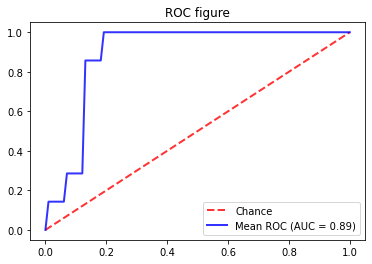

(110, 6, 417)
(110,)
Epoch 1/300
4/4 [==============================] - 0s 102ms/step - loss: 0.6711 - accuracy: 0.6768 - val_loss: 0.5733 - val_accuracy: 0.9091
Epoch 2/300
4/4 [==============================] - 0s 15ms/step - loss: 0.6330 - accuracy: 0.6869 - val_loss: 0.4611 - val_accuracy: 0.9091
Epoch 3/300
4/4 [==============================] - 0s 9ms/step - loss: 0.6143 - accuracy: 0.6768 - val_loss: 0.4148 - val_accuracy: 0.9091
Epoch 4/300
4/4 [==============================] - 0s 8ms/step - loss: 0.6131 - accuracy: 0.6768 - val_loss: 0.3888 - val_accuracy: 0.9091
Epoch 5/300
4/4 [==============================] - 0s 10ms/step - loss: 0.6060 - accuracy: 0.6768 - val_loss: 0.3980 - val_accuracy: 0.9091
Epoch 6/300
4/4 [==============================] - 0s 13ms/step - loss: 0.6144 - accuracy: 0.6768 - val_loss: 0.4513 - val_accuracy: 0.9091
Epoch 7/300
4/4 [==============================] - 0s 14ms/step - loss: 0.5993 - accuracy: 0.7071 - val_loss: 0.4372 - val_accuracy: 0.9091


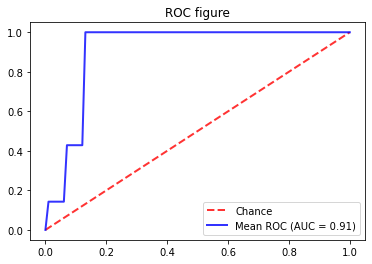

(120, 6, 417)
(120,)
Epoch 1/300
4/4 [==============================] - 0s 79ms/step - loss: 0.6803 - accuracy: 0.6389 - val_loss: 0.6027 - val_accuracy: 0.9167
Epoch 2/300
4/4 [==============================] - 0s 10ms/step - loss: 0.6511 - accuracy: 0.6574 - val_loss: 0.5555 - val_accuracy: 0.9167
Epoch 3/300
4/4 [==============================] - 0s 11ms/step - loss: 0.6396 - accuracy: 0.6574 - val_loss: 0.5483 - val_accuracy: 0.9167
Epoch 4/300
4/4 [==============================] - 0s 12ms/step - loss: 0.6380 - accuracy: 0.6574 - val_loss: 0.4934 - val_accuracy: 0.9167
Epoch 5/300
4/4 [==============================] - 0s 12ms/step - loss: 0.6209 - accuracy: 0.6944 - val_loss: 0.4515 - val_accuracy: 0.9167
Epoch 6/300
4/4 [==============================] - 0s 10ms/step - loss: 0.6088 - accuracy: 0.7037 - val_loss: 0.4273 - val_accuracy: 0.9167
Epoch 7/300
4/4 [==============================] - 0s 10ms/step - loss: 0.6038 - accuracy: 0.6759 - val_loss: 0.4245 - val_accuracy: 0.9167

4/4 [==============================] - 0s 8ms/step - loss: 0.2342 - accuracy: 0.8981 - val_loss: 0.2803 - val_accuracy: 0.9167
Epoch 60/300
4/4 [==============================] - 0s 8ms/step - loss: 0.2303 - accuracy: 0.9167 - val_loss: 0.4242 - val_accuracy: 0.8333
Epoch 61/300
4/4 [==============================] - 0s 8ms/step - loss: 0.2159 - accuracy: 0.9537 - val_loss: 0.1181 - val_accuracy: 0.9167
Epoch 62/300
4/4 [==============================] - 0s 8ms/step - loss: 0.2493 - accuracy: 0.8704 - val_loss: 0.2124 - val_accuracy: 0.9167
Epoch 63/300
4/4 [==============================] - 0s 7ms/step - loss: 0.2239 - accuracy: 0.8889 - val_loss: 0.2496 - val_accuracy: 0.9167
Epoch 64/300
4/4 [==============================] - 0s 8ms/step - loss: 0.2120 - accuracy: 0.9259 - val_loss: 0.2222 - val_accuracy: 0.9167
Epoch 65/300
4/4 [==============================] - 0s 8ms/step - loss: 0.3736 - accuracy: 0.8241 - val_loss: 0.5358 - val_accuracy: 0.8333
Epoch 66/300
4/4 [===============

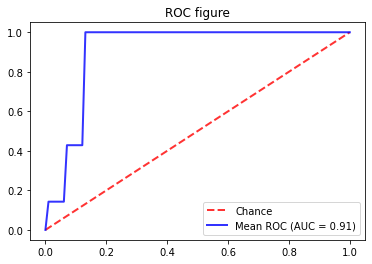

(130, 6, 417)
(130,)
Epoch 1/300
4/4 [==============================] - 0s 77ms/step - loss: 0.6863 - accuracy: 0.5897 - val_loss: 0.6016 - val_accuracy: 0.9231
Epoch 2/300
4/4 [==============================] - 0s 9ms/step - loss: 0.6591 - accuracy: 0.6410 - val_loss: 0.5599 - val_accuracy: 0.9231
Epoch 3/300
4/4 [==============================] - 0s 9ms/step - loss: 0.6451 - accuracy: 0.6838 - val_loss: 0.5178 - val_accuracy: 0.9231
Epoch 4/300
4/4 [==============================] - 0s 8ms/step - loss: 0.6354 - accuracy: 0.6496 - val_loss: 0.5054 - val_accuracy: 0.9231
Epoch 5/300
4/4 [==============================] - 0s 8ms/step - loss: 0.6280 - accuracy: 0.6923 - val_loss: 0.4807 - val_accuracy: 0.9231
Epoch 6/300
4/4 [==============================] - 0s 8ms/step - loss: 0.6211 - accuracy: 0.7265 - val_loss: 0.4605 - val_accuracy: 0.9231
Epoch 7/300
4/4 [==============================] - 0s 8ms/step - loss: 0.6168 - accuracy: 0.6923 - val_loss: 0.4283 - val_accuracy: 0.9231
Epoch

4/4 [==============================] - 0s 8ms/step - loss: 0.7051 - accuracy: 0.7265 - val_loss: 0.1875 - val_accuracy: 0.9231
Epoch 60/300
4/4 [==============================] - 0s 8ms/step - loss: 0.2803 - accuracy: 0.8718 - val_loss: 0.1982 - val_accuracy: 0.9231
Epoch 61/300
4/4 [==============================] - 0s 8ms/step - loss: 0.2667 - accuracy: 0.8974 - val_loss: 0.2106 - val_accuracy: 0.9231
Epoch 62/300
4/4 [==============================] - 0s 8ms/step - loss: 0.2401 - accuracy: 0.9060 - val_loss: 0.2149 - val_accuracy: 0.9231
f1_pred: 0.25
auc_pred 0.9017857142857143


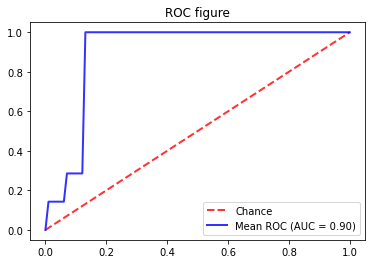

(140, 6, 417)
(140,)
Epoch 1/300
4/4 [==============================] - 0s 76ms/step - loss: 0.7037 - accuracy: 0.4762 - val_loss: 0.6324 - val_accuracy: 0.9286
Epoch 2/300
4/4 [==============================] - 0s 10ms/step - loss: 0.6727 - accuracy: 0.5952 - val_loss: 0.5770 - val_accuracy: 0.9286
Epoch 3/300
4/4 [==============================] - 0s 10ms/step - loss: 0.6590 - accuracy: 0.6111 - val_loss: 0.5364 - val_accuracy: 0.9286
Epoch 4/300
4/4 [==============================] - 0s 9ms/step - loss: 0.6543 - accuracy: 0.6667 - val_loss: 0.5112 - val_accuracy: 0.9286
Epoch 5/300
4/4 [==============================] - 0s 10ms/step - loss: 0.6397 - accuracy: 0.6587 - val_loss: 0.4897 - val_accuracy: 0.9286
Epoch 6/300
4/4 [==============================] - 0s 9ms/step - loss: 0.6399 - accuracy: 0.6905 - val_loss: 0.4671 - val_accuracy: 0.9286
Epoch 7/300
4/4 [==============================] - 0s 9ms/step - loss: 0.6300 - accuracy: 0.6746 - val_loss: 0.4517 - val_accuracy: 0.9286
Ep

4/4 [==============================] - 0s 9ms/step - loss: 0.3611 - accuracy: 0.8254 - val_loss: 0.3015 - val_accuracy: 0.9286
Epoch 60/300
4/4 [==============================] - 0s 9ms/step - loss: 0.3556 - accuracy: 0.8254 - val_loss: 0.3010 - val_accuracy: 0.9286
Epoch 61/300
4/4 [==============================] - 0s 13ms/step - loss: 0.3525 - accuracy: 0.8254 - val_loss: 0.2994 - val_accuracy: 0.9286
Epoch 62/300
4/4 [==============================] - 0s 14ms/step - loss: 0.3481 - accuracy: 0.8254 - val_loss: 0.2940 - val_accuracy: 0.9286
Epoch 63/300
4/4 [==============================] - 0s 12ms/step - loss: 0.3493 - accuracy: 0.8254 - val_loss: 0.2923 - val_accuracy: 0.9286
Epoch 64/300
4/4 [==============================] - 0s 9ms/step - loss: 0.3506 - accuracy: 0.8254 - val_loss: 0.2952 - val_accuracy: 1.0000
Epoch 65/300
4/4 [==============================] - 0s 8ms/step - loss: 0.3391 - accuracy: 0.8254 - val_loss: 0.2931 - val_accuracy: 1.0000
Epoch 66/300
4/4 [============

4/4 [==============================] - 0s 10ms/step - loss: 0.2433 - accuracy: 0.8968 - val_loss: 0.2248 - val_accuracy: 0.9286
Epoch 118/300
4/4 [==============================] - 0s 10ms/step - loss: 0.2426 - accuracy: 0.8889 - val_loss: 0.2279 - val_accuracy: 0.9286
Epoch 119/300
4/4 [==============================] - 0s 8ms/step - loss: 0.2408 - accuracy: 0.8968 - val_loss: 0.2261 - val_accuracy: 0.9286
Epoch 120/300
4/4 [==============================] - 0s 10ms/step - loss: 0.2410 - accuracy: 0.8889 - val_loss: 0.2297 - val_accuracy: 0.9286
Epoch 121/300
4/4 [==============================] - 0s 13ms/step - loss: 0.2394 - accuracy: 0.8889 - val_loss: 0.2278 - val_accuracy: 0.9286
Epoch 122/300
4/4 [==============================] - 0s 10ms/step - loss: 0.2376 - accuracy: 0.9048 - val_loss: 0.2213 - val_accuracy: 0.9286
Epoch 123/300
4/4 [==============================] - 0s 9ms/step - loss: 0.2362 - accuracy: 0.8968 - val_loss: 0.2229 - val_accuracy: 0.9286
Epoch 124/300
4/4 [===

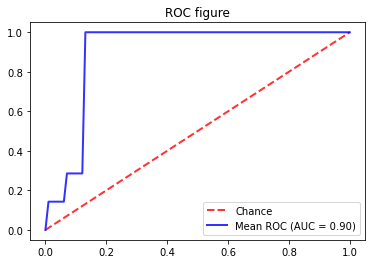

(150, 6, 417)
(150,)
Epoch 1/300
5/5 [==============================] - 0s 63ms/step - loss: 0.6849 - accuracy: 0.5481 - val_loss: 0.5833 - val_accuracy: 0.9333
Epoch 2/300
5/5 [==============================] - 0s 9ms/step - loss: 0.6631 - accuracy: 0.6222 - val_loss: 0.5595 - val_accuracy: 0.9333
Epoch 3/300
5/5 [==============================] - 0s 9ms/step - loss: 0.6665 - accuracy: 0.6222 - val_loss: 0.4868 - val_accuracy: 0.9333
Epoch 4/300
5/5 [==============================] - 0s 11ms/step - loss: 0.6340 - accuracy: 0.7037 - val_loss: 0.4792 - val_accuracy: 0.9333
Epoch 5/300
5/5 [==============================] - 0s 12ms/step - loss: 0.6286 - accuracy: 0.6741 - val_loss: 0.4571 - val_accuracy: 0.9333
Epoch 6/300
5/5 [==============================] - 0s 9ms/step - loss: 0.6200 - accuracy: 0.6519 - val_loss: 0.4407 - val_accuracy: 0.9333
Epoch 7/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6131 - accuracy: 0.7037 - val_loss: 0.4398 - val_accuracy: 0.9333
Epo

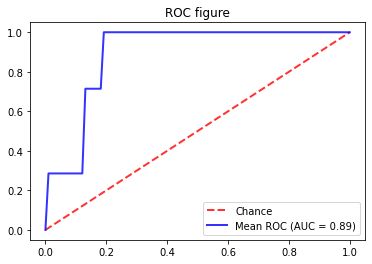

(160, 6, 417)
(160,)
Epoch 1/300
5/5 [==============================] - 0s 82ms/step - loss: 0.6926 - accuracy: 0.5972 - val_loss: 0.5908 - val_accuracy: 0.8750
Epoch 2/300
5/5 [==============================] - 0s 12ms/step - loss: 0.6625 - accuracy: 0.6528 - val_loss: 0.5463 - val_accuracy: 0.8750
Epoch 3/300
5/5 [==============================] - 0s 9ms/step - loss: 0.6352 - accuracy: 0.7083 - val_loss: 0.5100 - val_accuracy: 0.8750
Epoch 4/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6383 - accuracy: 0.6458 - val_loss: 0.4935 - val_accuracy: 0.8750
Epoch 5/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6278 - accuracy: 0.6250 - val_loss: 0.4717 - val_accuracy: 0.8750
Epoch 6/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6122 - accuracy: 0.7153 - val_loss: 0.4522 - val_accuracy: 0.8750
Epoch 7/300
5/5 [==============================] - 0s 8ms/step - loss: 0.5887 - accuracy: 0.7431 - val_loss: 0.4416 - val_accuracy: 0.8750
Epoc

5/5 [==============================] - 0s 9ms/step - loss: 0.1607 - accuracy: 0.9375 - val_loss: 0.1275 - val_accuracy: 0.9375
Epoch 60/300
5/5 [==============================] - 0s 9ms/step - loss: 0.1737 - accuracy: 0.9097 - val_loss: 0.2357 - val_accuracy: 0.9375
Epoch 61/300
5/5 [==============================] - 0s 8ms/step - loss: 0.1636 - accuracy: 0.9375 - val_loss: 0.1448 - val_accuracy: 0.9375
Epoch 62/300
5/5 [==============================] - 0s 8ms/step - loss: 0.1443 - accuracy: 0.9583 - val_loss: 0.2091 - val_accuracy: 0.9375
Epoch 63/300
5/5 [==============================] - 0s 8ms/step - loss: 0.1413 - accuracy: 0.9514 - val_loss: 0.1849 - val_accuracy: 0.9375
Epoch 64/300
5/5 [==============================] - 0s 8ms/step - loss: 0.1408 - accuracy: 0.9444 - val_loss: 0.1384 - val_accuracy: 0.9375
Epoch 65/300
5/5 [==============================] - 0s 8ms/step - loss: 0.1569 - accuracy: 0.9167 - val_loss: 0.1904 - val_accuracy: 0.9375
Epoch 66/300
5/5 [===============

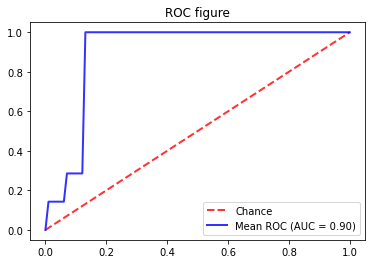

(170, 6, 417)
(170,)
Epoch 1/300
5/5 [==============================] - 0s 71ms/step - loss: 0.7113 - accuracy: 0.5163 - val_loss: 0.6421 - val_accuracy: 0.8824
Epoch 2/300
5/5 [==============================] - 0s 12ms/step - loss: 0.6668 - accuracy: 0.6667 - val_loss: 0.6020 - val_accuracy: 0.8824
Epoch 3/300
5/5 [==============================] - 0s 9ms/step - loss: 0.6548 - accuracy: 0.6405 - val_loss: 0.5683 - val_accuracy: 0.8824
Epoch 4/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6383 - accuracy: 0.6601 - val_loss: 0.5324 - val_accuracy: 0.8824
Epoch 5/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6352 - accuracy: 0.6405 - val_loss: 0.5203 - val_accuracy: 0.8824
Epoch 6/300
5/5 [==============================] - 0s 9ms/step - loss: 0.6156 - accuracy: 0.7647 - val_loss: 0.4962 - val_accuracy: 0.8824
Epoch 7/300
5/5 [==============================] - 0s 11ms/step - loss: 0.6042 - accuracy: 0.6993 - val_loss: 0.4842 - val_accuracy: 0.8824
Epo

5/5 [==============================] - 0s 9ms/step - loss: 0.1597 - accuracy: 0.9281 - val_loss: 0.2188 - val_accuracy: 0.9412
Epoch 60/300
5/5 [==============================] - 0s 8ms/step - loss: 0.1771 - accuracy: 0.9346 - val_loss: 0.1647 - val_accuracy: 0.9412
Epoch 61/300
5/5 [==============================] - 0s 8ms/step - loss: 0.6831 - accuracy: 0.7124 - val_loss: 0.3143 - val_accuracy: 0.8824
Epoch 62/300
5/5 [==============================] - 0s 8ms/step - loss: 0.5139 - accuracy: 0.8431 - val_loss: 0.1934 - val_accuracy: 0.9412
Epoch 63/300
5/5 [==============================] - 0s 7ms/step - loss: 0.1951 - accuracy: 0.9412 - val_loss: 0.1817 - val_accuracy: 0.9412
Epoch 64/300
5/5 [==============================] - 0s 8ms/step - loss: 0.1680 - accuracy: 0.9542 - val_loss: 0.1802 - val_accuracy: 0.9412
Epoch 65/300
5/5 [==============================] - 0s 7ms/step - loss: 0.1657 - accuracy: 0.9542 - val_loss: 0.1783 - val_accuracy: 0.9412
Epoch 66/300
5/5 [===============

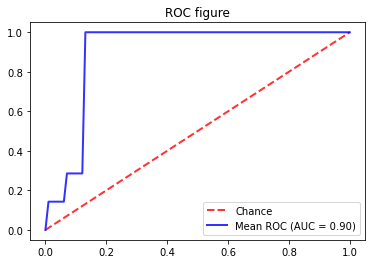

(180, 6, 417)
(180,)
Epoch 1/300
6/6 [==============================] - 0s 51ms/step - loss: 0.6923 - accuracy: 0.5494 - val_loss: 0.6006 - val_accuracy: 0.8889
Epoch 2/300
6/6 [==============================] - 0s 7ms/step - loss: 0.6584 - accuracy: 0.6728 - val_loss: 0.6353 - val_accuracy: 0.8889
Epoch 3/300
6/6 [==============================] - 0s 7ms/step - loss: 0.7138 - accuracy: 0.6049 - val_loss: 0.4902 - val_accuracy: 0.8889
Epoch 4/300
6/6 [==============================] - 0s 7ms/step - loss: 0.6653 - accuracy: 0.5988 - val_loss: 0.5011 - val_accuracy: 0.8889
Epoch 5/300
6/6 [==============================] - 0s 7ms/step - loss: 0.6593 - accuracy: 0.6420 - val_loss: 0.4744 - val_accuracy: 0.8889
Epoch 6/300
6/6 [==============================] - 0s 7ms/step - loss: 0.6469 - accuracy: 0.6235 - val_loss: 0.4724 - val_accuracy: 0.8889
Epoch 7/300
6/6 [==============================] - 0s 7ms/step - loss: 0.6256 - accuracy: 0.6420 - val_loss: 0.5374 - val_accuracy: 0.8889
Epoch

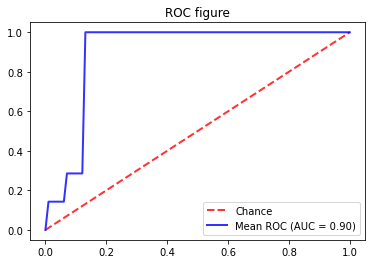

(190, 6, 417)
(190,)
Epoch 1/300
6/6 [==============================] - 0s 80ms/step - loss: 0.6807 - accuracy: 0.6082 - val_loss: 0.5912 - val_accuracy: 0.8947
Epoch 2/300
6/6 [==============================] - 0s 8ms/step - loss: 0.6622 - accuracy: 0.6257 - val_loss: 0.5435 - val_accuracy: 0.8947
Epoch 3/300
6/6 [==============================] - 0s 8ms/step - loss: 0.6495 - accuracy: 0.5965 - val_loss: 0.5197 - val_accuracy: 0.8947
Epoch 4/300
6/6 [==============================] - 0s 8ms/step - loss: 0.6312 - accuracy: 0.7193 - val_loss: 0.4793 - val_accuracy: 0.8947
Epoch 5/300
6/6 [==============================] - 0s 7ms/step - loss: 0.6265 - accuracy: 0.6901 - val_loss: 0.5016 - val_accuracy: 0.8947
Epoch 6/300
6/6 [==============================] - 0s 8ms/step - loss: 0.6085 - accuracy: 0.7135 - val_loss: 0.4707 - val_accuracy: 0.8947
Epoch 7/300
6/6 [==============================] - 0s 8ms/step - loss: 0.5783 - accuracy: 0.7719 - val_loss: 0.4468 - val_accuracy: 0.8947
Epoch

6/6 [==============================] - 0s 7ms/step - loss: 0.1291 - accuracy: 0.9415 - val_loss: 0.2648 - val_accuracy: 0.8947
Epoch 60/300
6/6 [==============================] - 0s 8ms/step - loss: 0.1243 - accuracy: 0.9474 - val_loss: 0.2150 - val_accuracy: 0.9474
Epoch 61/300
6/6 [==============================] - 0s 7ms/step - loss: 0.1226 - accuracy: 0.9649 - val_loss: 0.1794 - val_accuracy: 0.9474
Epoch 62/300
6/6 [==============================] - 0s 7ms/step - loss: 0.1163 - accuracy: 0.9532 - val_loss: 0.1195 - val_accuracy: 0.9474
Epoch 63/300
6/6 [==============================] - 0s 7ms/step - loss: 0.1343 - accuracy: 0.9415 - val_loss: 0.2118 - val_accuracy: 0.9474
Epoch 64/300
6/6 [==============================] - 0s 7ms/step - loss: 0.1223 - accuracy: 0.9591 - val_loss: 0.1142 - val_accuracy: 0.9474
f1_pred: 0.25
auc_pred 0.9017857142857143


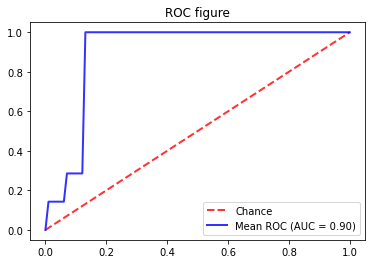

In [ ]:
### concatenate the orignal train/val data and generate data ###
for i in range(10):
    gen_data,y_gan=generate_data(0.1)
    x_train=np.concatenate((gen_data,x_train))
    y_train=np.concatenate((y_gan,y_train))
    print(x_train.shape)
    print(y_train.shape)
    data=(x_train, y_train), (x_test, y_test)
    ### train and val using generate data
    auc=build_and_train_lstm_models(data)
    aucs.append(auc)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.8928571428571429, 0.8928571428571429, 0.9107142857142857, 0.9107142857142857, 0.9017857142857143, 0.9017857142857143, 0.8928571428571428, 0.9017857142857143, 0.9017857142857143, 0.9017857142857143, 0.9017857142857143]


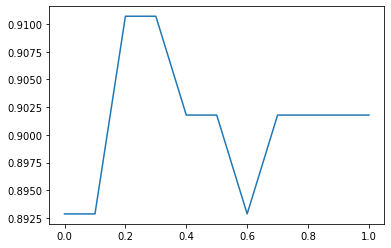

In [ ]:
x=np.linspace(0,1,11)
plt.plot(x,aucs)
print(x)
print(aucs)